# Modelling and analysing RNA circuit dynamics

Computational tools in synthetic biology are becoming increasingly sophisticated. Here, we are taking a closer look at what the RNA circuit dynamics modeller is doing under the hood and make sure that all the analytics that we are reading out of the dynamics are what we would expect.

<!-- The first comprehensive cell simulation was published recently for E. coli [reference] and it seems that every week there is a new neural network-based predictor for core genetic parts such as promoters, toehold sequences and and ribosome binding sites [references]. -->

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [69]:
from functools import partial
from typing import Optional, Tuple
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'gpu')
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.70" 

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.misc.numerical import add_recursively
from synbio_morpher.utils.misc.type_handling import append_nest_dicts
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller

CONFIG = prepare_config(CONFIG)
root_dir = '..'

We will import some data summarising a previous simulation of 2000 randomly generated RNA circuits and their mutated iterations. For each starting or "reference" circuit, a mutated circuit was generated with $m$ mutations on each RNA species $s$ in the circuit. Because each of these mutations is administered randomly, some $n$ number of versions is repeated for each mutated iteration with $m$ mutations on species $s$. The exact settings for this dataset were the following:

$$
m = [1, 2, 3, 5, 10, 15]
$$
$$
s = [RNA_0, RNA_1, RNA_2]
$$
$$
n = 10
$$

This means that for each circuit, 6 mutated iterations $m$ were generated for each of the 3 RNA species $s$ with $n = 10$ samples for each, giving 180 mutated circuits for each reference circuit and thus a total of $2000 * 181 = 362000$ circuits.

# Case study: studying specific circuits' dynamics


## Choosing circuits with similar and different dynamics

In order to find good candidates for a case study, we want to look at circuits where some have similar dynamics metrics between them, some have vastly different dynamics but similar values, and some have highly varying metrics on all accounts. We especially want to look at circuits with possible contradictions, such as those where the minimum and maximum values reached by the signalling RNA ($RNA_0$) are similar, yet some of the signal analytics suggest a big change between these values.

### Load Data

In [3]:
# fn = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
# fn = '../data/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
# og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'
data = pd.read_csv(fn)
# data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
# dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)


In [4]:
data = data.drop(data[data['sample_name'].isna()].index)

In [5]:
config = load_json_as_dict(os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
# config = load_json_as_dict('/home/wadh6511/Kode/synbio_morpher/data/summarise_simulation/2023_07_17_222747/mutation_experiment.json')
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'

### Get means and STDs

In [6]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c)]
# agg1 = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: 'std' for c in analytics})
agg1_stds = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.std(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})

### Find circuits with optimal distance in their function

Here we are looking at the circuits with minimal distance between their sensitivities and precisions, while having a maximum distance between the variation of the change in their precision between reference and mutated circuits, so the standard deviation of the precision ratio between from a mutant to it reference circuit.

In [133]:

def find_similar_distant_circuits(similars: tuple, distants: tuple, weights: Optional[tuple]=None, uselog=True) -> Tuple[int]:
    def calculate_diffs(og):
        similars_diff = f(og[:, None] / og[None, :])
        return np.where(np.isnan(similars_diff) | (np.abs(similars_diff) == np.inf), 0, similars_diff)
    
    if weights is None:
        weights = np.ones(len(similars) * len(distants))
    f = np.log if uselog else vanilla_return

    similars_diffs = [calculate_diffs(similar) for similar in similars]
    distants_diffs = [calculate_diffs(distant) for distant in distants]
        
    joint_similars = np.zeros(similars_diffs[0].shape)
    for d, w in zip(similars_diffs, weights[:len(similars)]):
        joint_similars += w * np.abs(d)
    joint_similars = np.where(joint_similars != 0, joint_similars.max() - np.abs(joint_similars), 0)
        
    joint_distants = np.zeros(distants_diffs[0].shape)
    for d, w in zip(distants_diffs, weights[len(similars):]):
        joint_distants += w * np.abs(d)

    joint = joint_similars + joint_distants

    circ1, circ2 = np.where(joint == np.abs(joint).max()) 
    circ1, circ2 = np.array(list(set([tuple(sorted([c1, c2])) for c1, c2 in zip(circ1, circ2)]))).T
    
    return circ1, circ2


In [94]:
filts = (agg1_mean['sample_name'] == 'RNA_2') & (agg1_mean['precision_wrt_species-6'] != np.inf) & (
    agg1_mean['precision_wrt_species-6'] > 2) & ((agg1_mean['num_interacting'] > 1) | (agg1_mean['num_self_interacting'] > 1))

circ1, circ2 = find_similar_distant_circuits(
    similars = [agg1_mean[filts][s].to_numpy() for s in ['precision_wrt_species-6', 'sensitivity_wrt_species-6']],
    distants = [agg1_stds[filts]['precision_wrt_species-6_ratio_from_mutation_to_base'].to_numpy()],
    weights=(1, 1, 0.1))

circ1_m_df = agg1_mean[filts].iloc[circ1]
circ2_m_df = agg1_mean[filts].iloc[circ2]
circ1_s_df = agg1_stds[filts].iloc[circ1]
circ2_s_df = agg1_stds[filts].iloc[circ2]


/tmp/ipykernel_1030/1105099669.py:9: RuntimeWarning: divide by zero encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_1030/1105099669.py:9: RuntimeWarning: invalid value encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_1030/1105099669.py:9: RuntimeWarning: divide by zero encountered in log
  std_diffs = np.log(st[:, None] / st[None, :])


In [134]:
find_similar_distant_circuits(
    similars = [agg1_mean[filts][s].to_numpy() for s in ['precision_wrt_species-6', 'sensitivity_wrt_species-6']],
    distants = [agg1_stds[filts]['precision_wrt_species-6_ratio_from_mutation_to_base'].to_numpy()],
    weights=(1, 1, 0.1))

# similars = [agg1_mean[filts][s].to_numpy() for s in ['precision_wrt_species-6', 'sensitivity_wrt_species-6']]
# distants = [agg1_stds[filts]['precision_wrt_species-6_ratio_from_mutation_to_base'].to_numpy()]
# weights=(1, 1, 0.1)

# uselog = True
# def calculate_diffs(og):
#     similars_diff = f(og[:, None] / og[None, :])
#     return np.where(np.isnan(similars_diff) | (np.abs(similars_diff) == np.inf), 0, similars_diff)

# if weights is None:
#     weights = np.ones(len(similars) * len(distants))
# f = np.log if uselog else vanilla_return

# similars_diffs = [calculate_diffs(similar) for similar in similars]
# distants_diffs = [calculate_diffs(distant) for distant in distants]
    
# joint_similars = np.zeros(similars_diffs[0].shape)
# for d, w in zip(similars_diffs, weights[:len(similars)]):
#     joint_similars += w * np.abs(d)
# joint_similars = np.where(joint_similars != 0, joint_similars.max() - np.abs(joint_similars), 0)
    
# joint_distants = np.zeros(distants_diffs[0].shape)
# for d, w in zip(distants_diffs, weights[len(similars):]):
#     joint_distants += w * np.abs(d)

# jointi = joint_similars + joint_distants

# circ1i, circ2i = np.where(jointi == np.abs(jointi).max()) 
# circ1i, circ2i = np.array(list(set([tuple(sorted([c1, c2])) for c1, c2 in zip(circ1i, circ2i)]))).T

# circ1i, circ2i

/tmp/ipykernel_1030/3147364566.py:3: RuntimeWarning: divide by zero encountered in divide
  similars_diff = f(og[:, None] / og[None, :])
/tmp/ipykernel_1030/3147364566.py:3: RuntimeWarning: invalid value encountered in divide
  similars_diff = f(og[:, None] / og[None, :])
/tmp/ipykernel_1030/3147364566.py:3: RuntimeWarning: divide by zero encountered in log
  similars_diff = f(og[:, None] / og[None, :])


(array([495]), array([1379]))

Let's also select some robust and unstable circuits with large overshoots.

### Check that the expected circuits were selected

Visualising the precision and sensitivity of the circuits, along with the variation in precision ratio.

Text(0.5, 0.98, 'Precision mean for $RNA_2$')

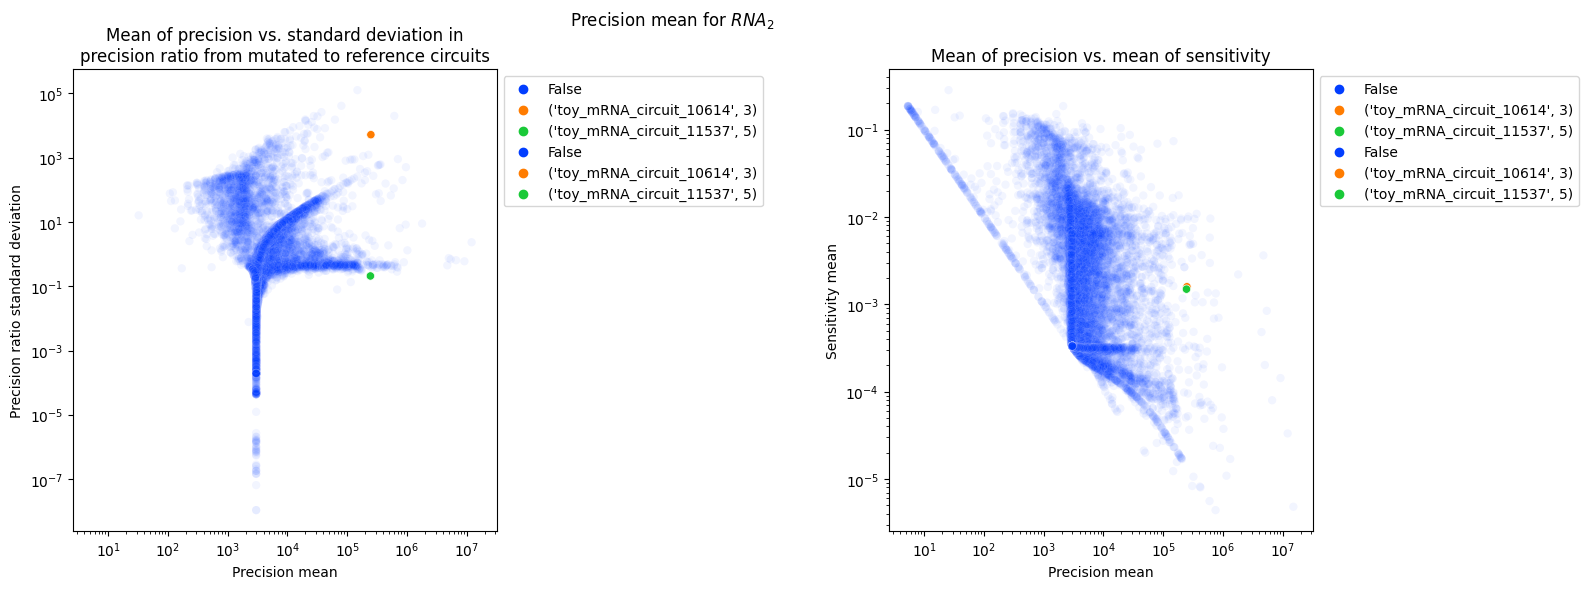

In [8]:
filt = (agg1_mean['precision_wrt_species-6'] < np.inf) & (agg1_mean['sample_name'] == 'RNA_2')
c1n, c1m = circ1_m_df['circuit_name'].values[0], circ1_m_df['mutation_num'].values[0]
c2n, c2m = circ2_m_df['circuit_name'].values[0], circ2_m_df['mutation_num'].values[0]
hue_d = {c1n: c1m, c2n: c2m}
# hue = jax.tree_util.tree_map(lambda c, m: (c,m) if (c in [c1n, c2n]) and (m == hue_d[c]) else False, list(agg1_mean[filt]['circuit_name'].values), list(agg1_mean[filt]['mutation_num'].values))
hue = list(map(lambda i, c, m: (c, m) if (i == circ1_m_df.index[0]) or (i == circ2_m_df.index[0]) else False, 
               list(agg1_mean[filt].index), list(agg1_mean[filt]['circuit_name'].values), list(agg1_mean[filt]['mutation_num'].values)))
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(wspace=0.925)

ax = plt.subplot(1,2,1)
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_stds[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_stds[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision ratio standard deviation')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutated to reference circuits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

filt = (agg1_mean['precision_wrt_species-6'] < np.inf) & (agg1_mean['sensitivity_wrt_species-6'] < np.inf) & (agg1_mean['sample_name'] == 'RNA_2')
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

ax = plt.subplot(1,2,2)
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_mean[filt]['sensitivity_wrt_species-6'], 
                alpha=0.05,
                hue=hue,
                palette="bright")
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_mean[filt]['sensitivity_wrt_species-6'], 
                alpha=alpha,
                hue=hue,
                palette="bright")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precision mean')
plt.ylabel('Sensitivity mean')
plt.title('Mean of precision vs. mean of sensitivity')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

plt.suptitle('Precision mean for $RNA_2$')



As you can see from graphs above, the 2 circuits chosen are very close in terms of their average precision and sensitivity (right graph), but over 2 orders of magnitude apart in the variation of their precision ratio change from mutated to reference circuit (left graph).

## Simulate the chosen circuits

### Load circuits

We will load the two circuits selected and all the circuits with same reference circuit. 

In [9]:


def load_circuit(circ_row, config, og_dir: str):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        if np.power(length, 2) == len(flattened_vector):
            length = int(np.sqrt(len(flattened_vector)))
            return flattened_vector.reshape((length, length))
        
        matrix = [[0] * length for _ in range(length)]
        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1
        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')].values.squeeze()),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')].values.squeeze()),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')].values.squeeze()),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')].values.squeeze())}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,  #.replace('toy_mRNA_circuit_', 'toy_circuit_combo0_'),
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

def batch_load(circ_rows: pd.DataFrame, ref_c: pd.DataFrame, og_dir: str, config: dict):
    circuits = []
    circuits.append(load_circuit(circ_row=ref_c.iloc[0], config=config, og_dir=og_dir))
    for i, circ_row in circ_rows.iterrows():
        circuits.append(load_circuit(circ_row=circ_row, config=config, og_dir=og_dir))
    return circuits

circ_rows1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & ((data['num_interacting'] != 0) | (data['num_self_interacting'] != 0)) & (data['sample_name'] == 'RNA_2')]
ref_c1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_2')]
circ_rows2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ2_m_df['mutation_num'].values[0]) & ((data['num_interacting'] != 0) | (data['num_self_interacting'] != 0)) & (data['sample_name'] == 'RNA_2')]
ref_c2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_2')]
circuits1 = batch_load(circ_rows1, ref_c1, og_dir, config)
circuits2 = batch_load(circ_rows2, ref_c2, og_dir, config)
circuits = circuits1 + circuits2




xla_bridge.py:backends():603: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA INFO
xla_bridge.py:backends():603: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO


We also load and set the simulation parameters, such as the total simulation time, time step $dt$, threshold for considering a time step as having reached steady state, etc. Certain parameters like the signal strength are loaded from the original config used to generate the data in the first place.

In [10]:

signal_target = config['signal']['function_kwargs']['target']
signal_target

2

In [11]:

forward_rates = circuits1[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])

t0 = 0 
t1 = 100
dt = 0.001
tmax = 5000
threshold_steady_states = 0.01
save_steps = 500  # int(np.min([200, t1-t0]))

signal_onehot = np.zeros_like(circuits1[0].signal.reactions_onehot) if circuits1[0].use_prod_and_deg else np.zeros_like(circuits1[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits1[0].qreactions.reactions.inputs,
                            outputs=circuits1[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, save_steps))
                            )))

Below the actual simulation functions are run. Tirst the steady states of the unperturbed system are simualted, then the signal is added. Each of these two steps take a few minutes.

In [12]:


signal = circuits[0].signal

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)

signal_species = 'RNA_0'
signal_species_idx = np.where(circuits1[0].signal.onehot)[0][0]

# b_steady_states = b_copynumbers[:, :, -1]
# b_steady_states[:, signal_species_idx] += b_copynumbers[:, signal_species_idx, 0] * signal_target

b_steady_states = (b_copynumbers[:, :, -1] * ((signal.onehot == 0) * 1)) + \
    (b_copynumbers[:, :, 0] *
     signal_target) * signal.onehot
                            
# b_steady_states[i] = c.result_collector.get_result(
#                             'steady_states').analytics['steady_states'].flatten() * ((signal.onehot == 0) * 1) + \
#                             (c.result_collector.get_result(
#                                 'steady_states').analytics['initial_steady_states'].flatten() *
#                              signal.func.keywords['target']) * signal.onehot


Done:  0:00:24.308913


In [13]:
b_copynumbers.shape

(58, 9, 500)

In [14]:

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)


# Fix first entry for signal species -> Warning: deletes final element in simulated data
for i, c in enumerate(circuits): 
    if not c.use_prod_and_deg:
        b_new_copynumbers[i, :, :] = np.concatenate([np.expand_dims(b_copynumbers[i, :, -1], axis=1), b_new_copynumbers[i, :, :-1]], axis=1)


Done:  0:00:22.609410


### Visualise traces

The traces of the two circuit families are plotted below. Each plot is labelled with whether it is the first or second comparative circuit, along with its circuit name and sub mutation name.

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

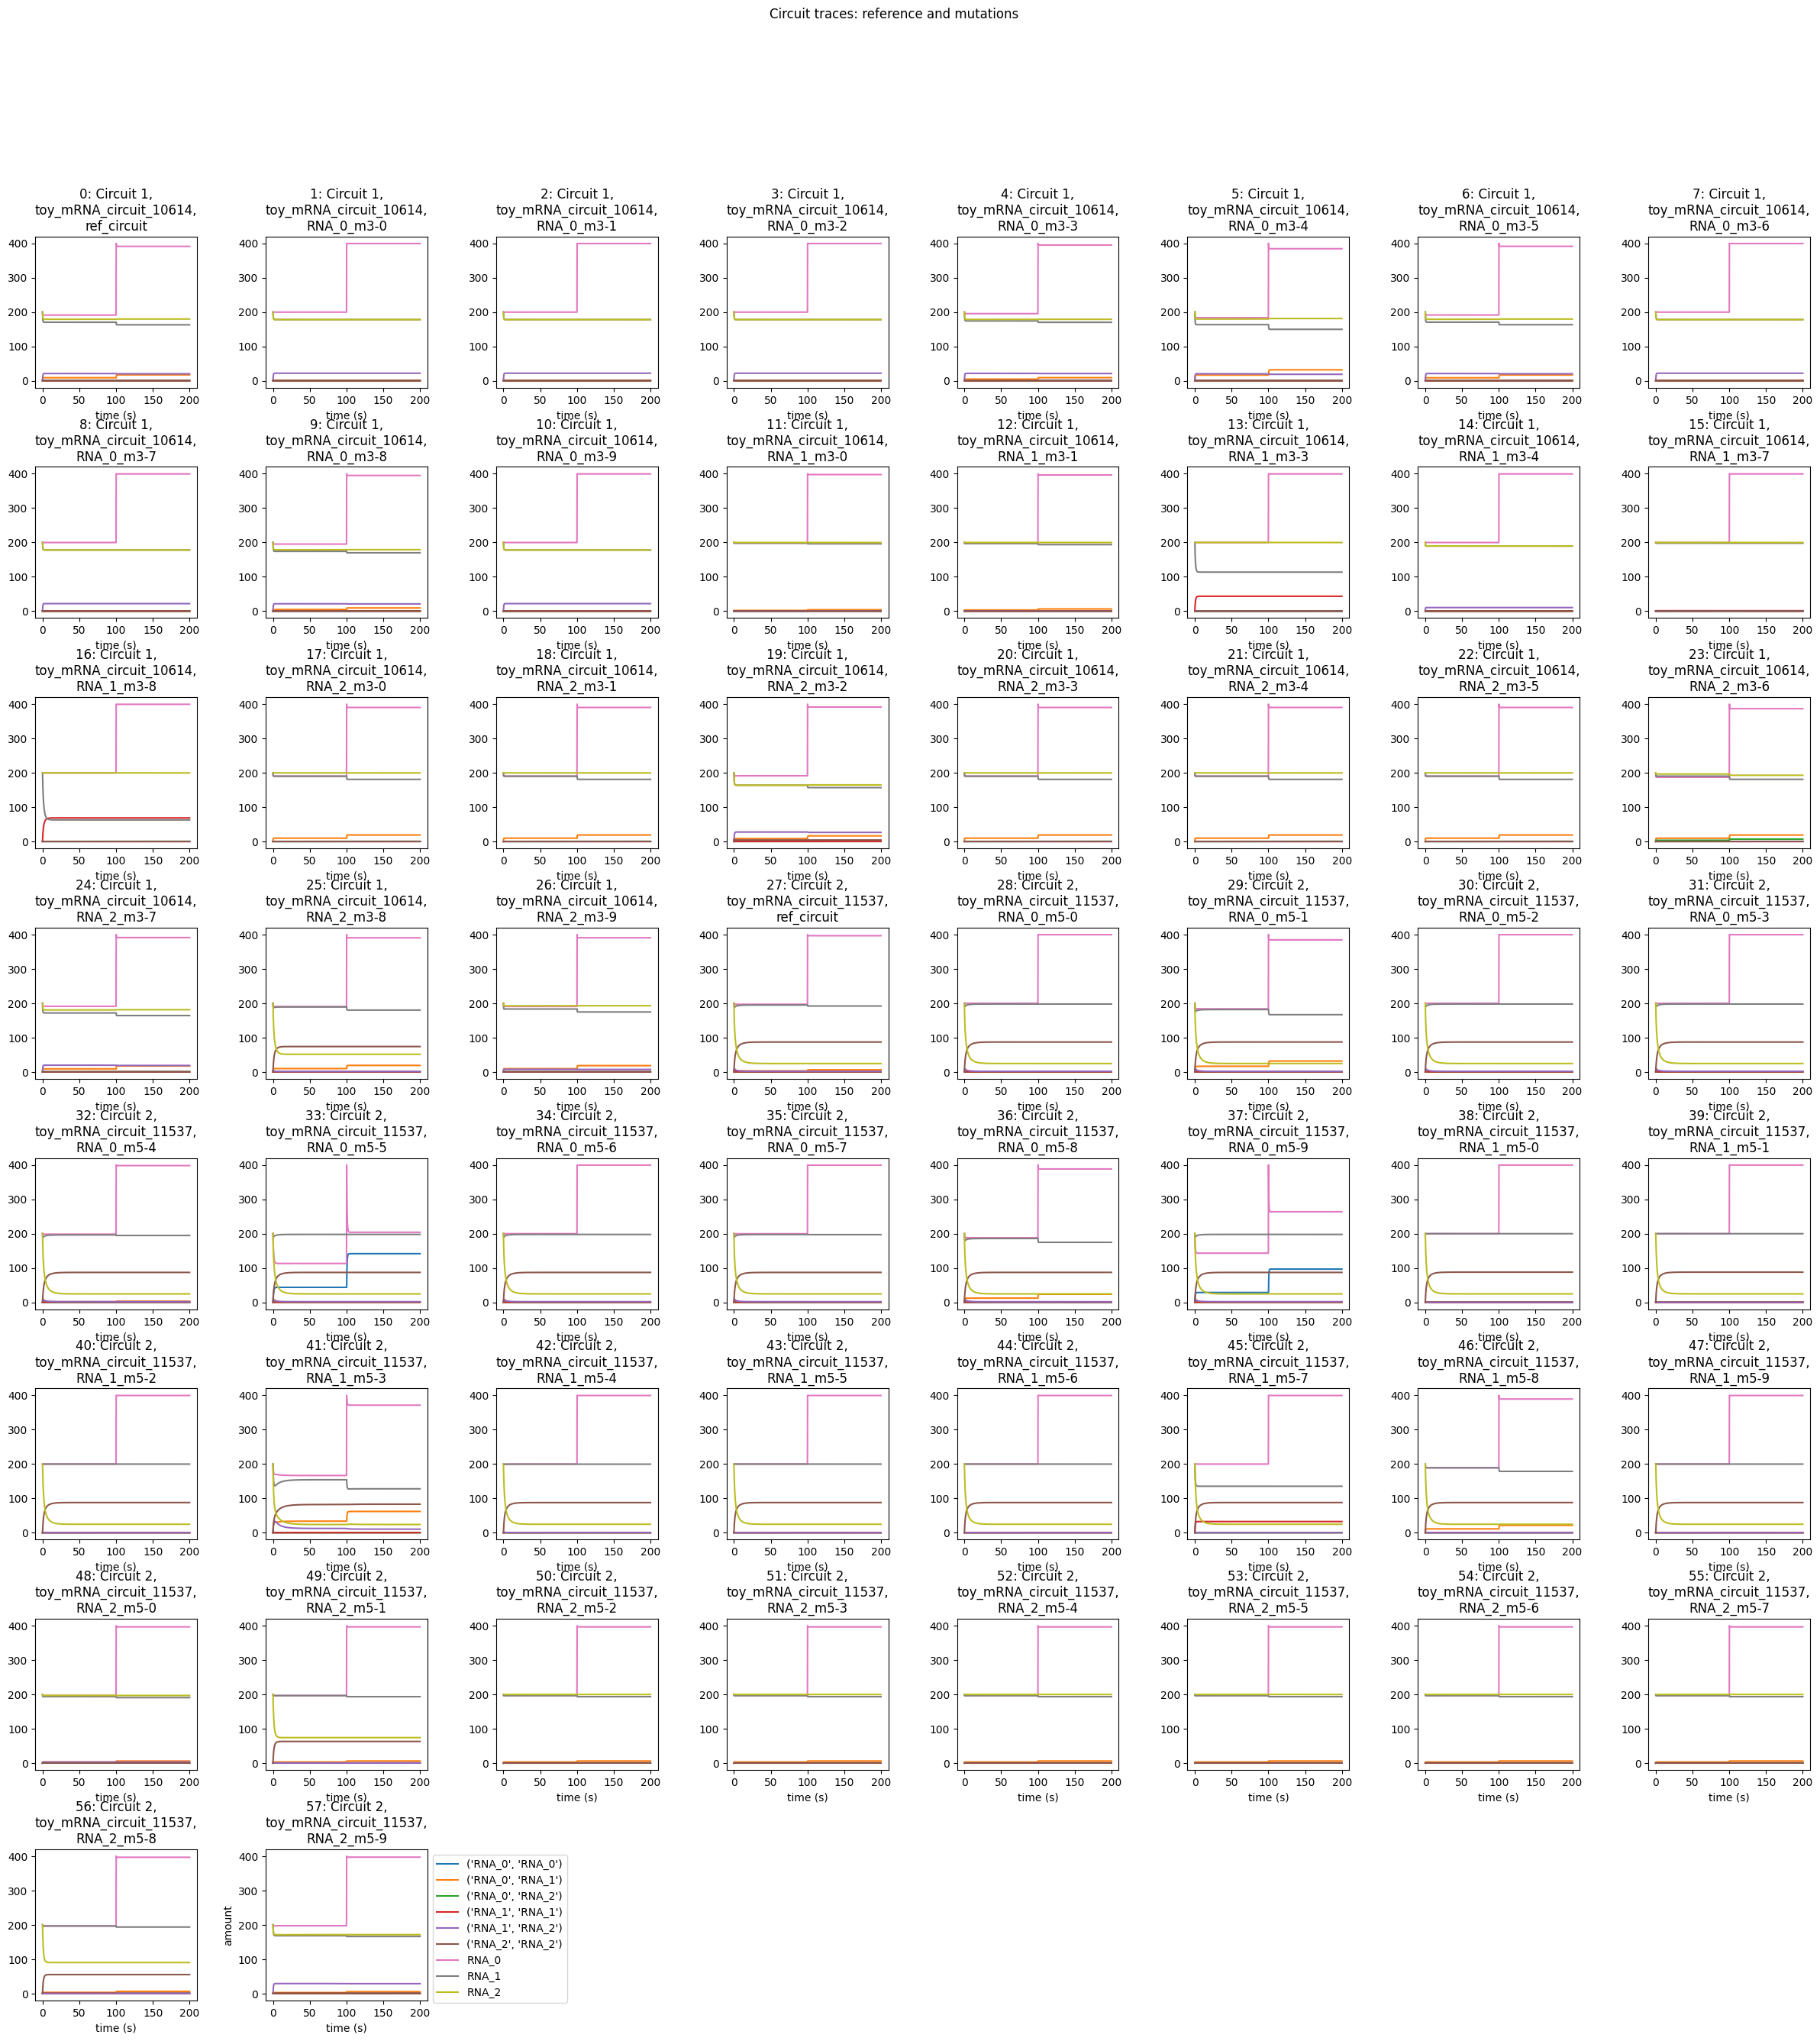

In [15]:
num_circuits = len(circuits)
nm=0
tdisplay = (0, len(tss) + len(tyy))
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.525, wspace=0.425)
for i, circ in enumerate(circuits):
    ax = plt.subplot(8,8,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]])[tdisplay[0]:tdisplay[1]], np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T])[tdisplay[0]:tdisplay[1]])
    circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
    plt.title(f'{i}: {circ_type},\n{circuits[i].name},\n{circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')


Let's zoom in at the point of signal addition.

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

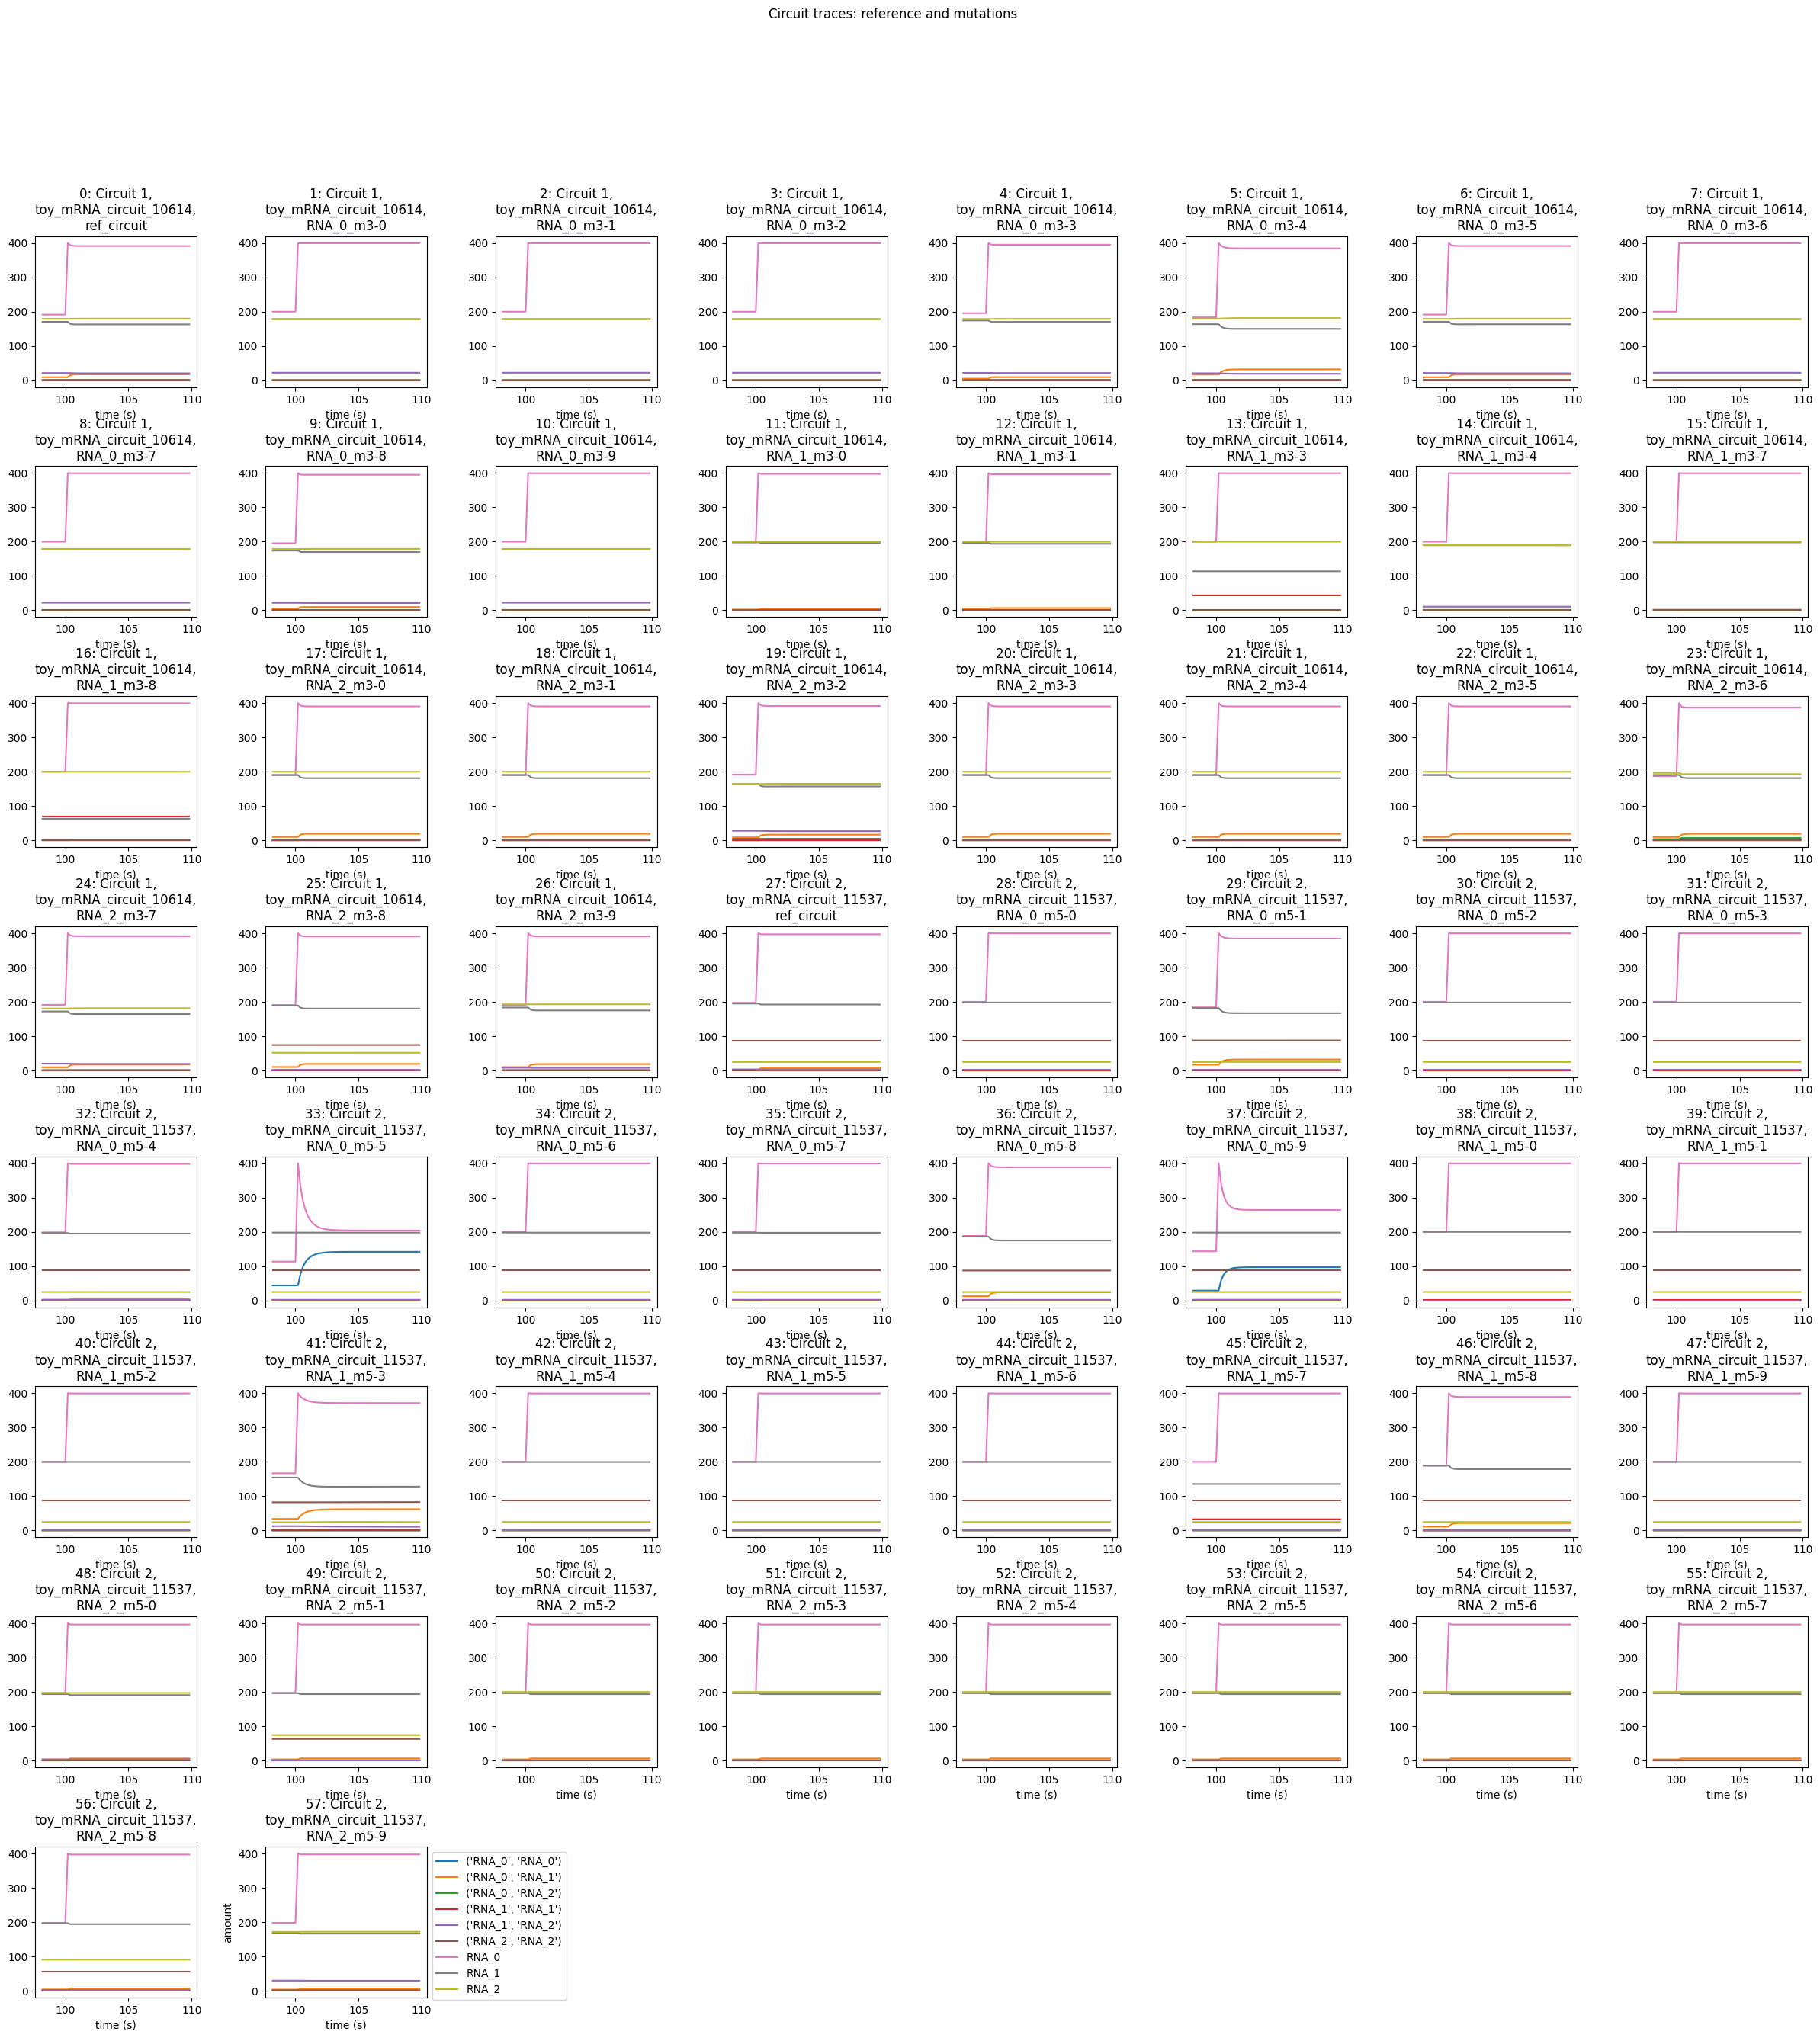

In [16]:
num_circuits = len(circuits)
nm=0
tdisplay = (len(tss) - 10, len(tss) + 50)
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.525, wspace=0.425)
for i, circ in enumerate(circuits):
    ax = plt.subplot(8,8,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]])[tdisplay[0]:tdisplay[1]], np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T])[tdisplay[0]:tdisplay[1]])
    circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
    plt.title(f'{i}: {circ_type},\n{circuits[i].name},\n{circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')


In [17]:

# print('Circuit 1')
# data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == circ1_m_df['sample_name'].values[0]) ][
#     ['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions', 'num_interacting', 'num_self_interacting', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
# ]

### Validate the analytics

As a sanity check, let's make sure that the analytics that we have in our `data` table are what we would expect from our simulations. This is primarily to check that all the simulated data is merged back into a summary table in the correct way.

In [18]:
t = np.concatenate([tss, tyy + tss[-1]])
all_copynumbers = np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T])
ref_idxs = [0, 26]
ref_idxs2 = ref_idxs[1:] + [len(circuits)]

b_analytics_l = []
for ref_idx, ref_idx2 in zip(ref_idxs, ref_idxs2):
    ref_circuit = circuits[ref_idx]
    signal = ref_circuit.signal
    ref_circuit_data = b_new_copynumbers[ref_idx]
    analytics_func = jax.vmap(partial(
        generate_analytics, time=tyy, labels=[
            s.name for s in ref_circuit.model.species],
        signal_onehot=signal.onehot, signal_time=signal.func.keywords[
            'impulse_center'],
        ref_circuit_data=ref_circuit_data))
    b_analytics = analytics_func(
        data=b_new_copynumbers[ref_idx:ref_idx2])
    b_analytics_l = append_nest_dicts(
        b_analytics_l, ref_idx2 - ref_idx, b_analytics)

The analytics calculated in this notebook do correspond to the correct circuit and to the previously simulated analytics in the original dataset. We will check the analytics calculated in this notebook with the ones listed in the data table using a specific circuit. 

#### Examining specific circuits more closely

After examining the grid of circuits, we will look at circuit #41 more closely, because there are a lot of different behaviors among the species. 

In [19]:
chosen_circuit_idx = 41

df_calculated_specific = pd.DataFrame({k: v.squeeze() for k, v in b_analytics_l[chosen_circuit_idx].items() if 'first_derivative' not in k}, index=np.arange(len(b_analytics_l[chosen_circuit_idx]['RMSE'].squeeze())))
df_calculated_specific

,RMSE,RMSE_diff_to_base_circuit,RMSE_ratio_from_mutation_to_base,fold_change,fold_change_diff_to_base_circuit,fold_change_ratio_from_mutation_to_base,initial_steady_states,initial_steady_states_diff_to_base_circuit,initial_steady_states_ratio_from_mutation_to_base,max_amount,...,precision_wrt_species-6_ratio_from_mutation_to_base,response_time_wrt_species-6,response_time_wrt_species-6_diff_to_base_circuit,response_time_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,steady_states,steady_states_diff_to_base_circuit,steady_states_ratio_from_mutation_to_base
0,0.024525,0.024525,inf,4.974398,0.768935,1.182842,0.046494,-0.014369,0.763918,0.255962,...,1.028468,2.607214,-inf,0.000000,3.212245,0.249790,1.084319,0.231279,-0.024676,0.903594
1,43.431126,43.431126,inf,1.848578,-0.106285,0.945631,33.461357,24.131395,3.586441,61.855927,...,1.434896,11.224449,11.222445,5600.945801,0.605033,-0.263126,0.696915,61.855927,43.617134,3.391448
2,0.111128,0.111128,inf,2.242842,0.189207,1.092133,0.006615,-0.054840,0.107643,0.015537,...,1.081050,inf,NaN,NaN,0.961588,-0.006129,0.993667,0.014837,-0.111370,0.117560
3,0.023672,0.023672,inf,0.686935,-0.221762,0.755956,0.039848,-0.016378,0.708714,0.039848,...,0.371899,15.633266,15.831663,-78.797974,0.226293,0.143280,2.725986,0.027373,-0.023719,0.535757
4,3.185088,3.185088,inf,0.833477,-0.121133,0.873108,12.238495,4.768135,1.638274,12.238495,...,0.347584,39.080162,39.078159,19500.812500,0.118730,0.077461,2.876999,10.200505,3.069227,1.430390
5,82.772232,82.772232,inf,1.011257,0.008414,1.008390,82.009811,81.947754,1321.577148,82.932968,...,0.322037,21.444889,21.643286,-108.090904,0.008026,0.005441,3.105237,82.932968,82.870735,1332.665283
6,19.205496,19.205496,inf,2.230335,0.179613,1.087585,166.491043,-23.996948,0.874024,400.000000,...,1.089020,1.805611,-inf,0.000000,1.000000,0.000000,1.000000,371.330872,-19.307159,0.950575
7,46.674854,46.674854,inf,0.828815,-0.124440,0.869458,154.133087,-28.955154,0.841851,154.133087,...,0.348206,1.004008,1.202405,-5.060606,0.123914,0.081414,2.915632,127.747849,-46.782043,0.731954
8,168.682968,168.682968,inf,1.005608,0.004187,1.004181,23.688757,-168.655655,0.123158,24.685266,...,0.323008,37.076153,37.274551,-186.878784,0.029993,0.028702,23.223558,23.821600,-168.796036,0.123673


Text(0, 0.5, 'amount')

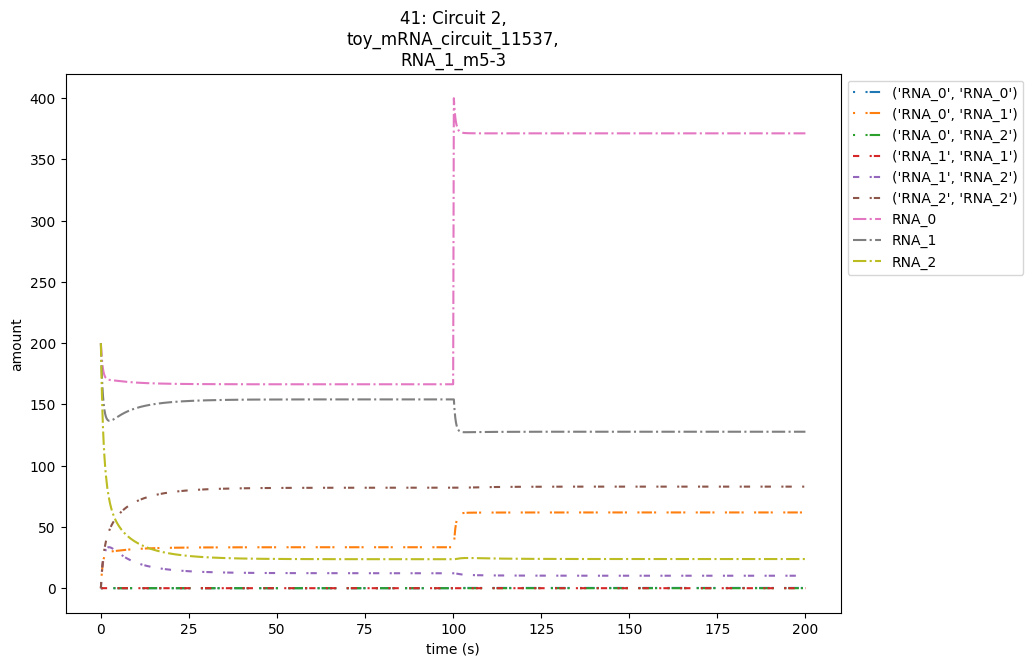

In [20]:
fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(hspace=0.525, wspace=0.425)

ax = plt.subplot(1,1,1)
line_styles = ((0, (1, 5, 1)), (0, (3,5,1,1)), '-.')
ns = b_copynumbers.shape[1]
for i, ls in enumerate(line_styles):
    s = (int((i * ns)/len(line_styles)), int((i * ns + ns)/len(line_styles)))
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), 
            np.concatenate([b_copynumbers[chosen_circuit_idx].T, b_new_copynumbers[chosen_circuit_idx].T])[:, s[0]:s[1]],
            linestyle=ls)
circ_type = 'Circuit 2' if circuits[chosen_circuit_idx] in circuits2 else 'Circuit 1'
plt.title(f'{chosen_circuit_idx}: {circ_type},\n{circuits[chosen_circuit_idx].name},\n{circuits[chosen_circuit_idx].subname}')
plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')


From the above graph, we should expect the traces that change the most upon signal introduction to have a low precision, while the traces that stay relatively static should have high precisions. Except for the signal species itself, there don't seem to be any noticeable overshoots either, so the precision should be roughly equal to $1 / sensitivity$ as well.

In [21]:
print(f'Precisions of all species for circuit {circuits[chosen_circuit_idx].name}: \n')

print(pd.DataFrame(data=zip(circuits[chosen_circuit_idx].model.species, df_calculated_specific['precision_wrt_species-6'].to_numpy(), 
                      1 / df_calculated_specific['sensitivity_wrt_species-6'].to_numpy(), df_calculated_specific['overshoot']),
                 columns=['species', 'precision', '1/sensitivity', 'overshoot']))

weird_species_idx = 3
output_diff = b_new_copynumbers[chosen_circuit_idx, :, -1] - b_new_copynumbers[chosen_circuit_idx, :, 0]
print(f'\n\nSpecies {circuits[chosen_circuit_idx].model.species[weird_species_idx]} has a relative output difference of:')
print(output_diff[weird_species_idx]/b_new_copynumbers[chosen_circuit_idx, weird_species_idx, 0])
print(f'while the relative difference in signal is ')
print((b_new_copynumbers[chosen_circuit_idx, signal_species_idx, 1] - b_new_copynumbers[chosen_circuit_idx, signal_species_idx, 0])/b_new_copynumbers[chosen_circuit_idx, signal_species_idx, 0])

Precisions of all species for circuit toy_mRNA_circuit_11537: 

                       species   precision  1/sensitivity  overshoot
0  Species: ('RNA_0', 'RNA_0')    0.352892       0.311309   0.024683
1  Species: ('RNA_0', 'RNA_1')    1.652802       1.652802   0.000000
2  Species: ('RNA_0', 'RNA_2')    1.128487       1.039947   0.000700
3  Species: ('RNA_1', 'RNA_1')    4.479997       4.419053   0.000172
4  Species: ('RNA_1', 'RNA_2')    8.422456       8.422456   0.000000
5  Species: ('RNA_2', 'RNA_2')  124.595703     124.595703   0.000000
6               Species: RNA_0    1.139959       1.000000  28.669128
7               Species: RNA_1    8.193086       8.070104   0.402092
8               Species: RNA_2  250.101456      33.340607   0.863667


Species Species: ('RNA_1', 'RNA_1') has a relative output difference of:
-0.31306535
while the relative difference in signal is 
1.4025316


The species $RNA_2$ has a higher than expected overshoot upon inspection of its sensitivity, even though this is difficult to tell from the graph. The bound species ($RNA_1$, $RNA_1$) (red) have a flat-looking trace that doesn't seem to react to the signal too much, yet its precision is very low. For this to be true, the difference between the final and initial states must be similar to the relative signal difference (ie fourfold), which is confirmed above. 

If we are looking for a highly adaptable circuit, then higher precision values are desirable. If the steady state of a species is at low molecular counts however, as with the bound species ($RNA_1$, $RNA_1$), the system may exhibit highly stochastic behavior. Therefore, desirable precision and sensitivity may lie within regions of undesirably low steady states, making a multiplexed selection approach essential.


Now let's look at another circuit and make sure we see similar outputs.

Text(0, 0.5, 'amount')

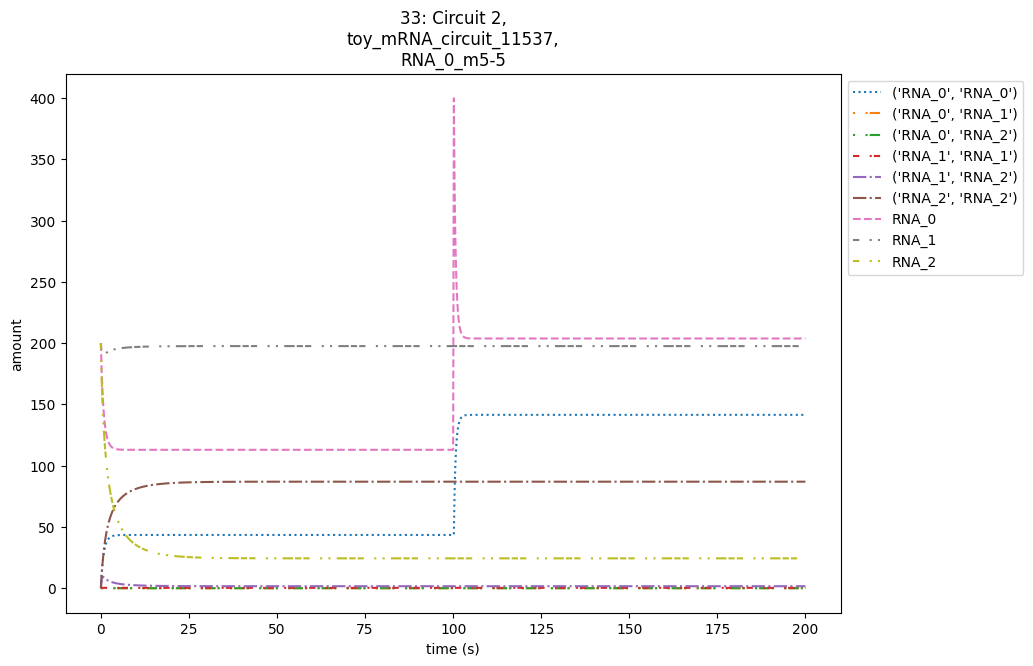

In [22]:
chosen_circuit_idx = 33

df_calculated_specific = pd.DataFrame({k: v.squeeze() for k, v in b_analytics_l[chosen_circuit_idx].items() if 'first_derivative' not in k}, index=np.arange(len(b_analytics_l[chosen_circuit_idx]['RMSE'].squeeze())))

fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(hspace=0.525, wspace=0.425)

ax = plt.subplot(1,1,1)
line_styles = (':', (0, (1, 5, 1)), (0, (3,5,1,1)), '-.', '--', (0, (3,5,1,3,1)))
ns = b_copynumbers.shape[1]
for i, ls in enumerate(line_styles):
    s = (int((i * ns)/len(line_styles)), int((i * ns + ns)/len(line_styles)))
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), 
            np.concatenate([b_copynumbers[chosen_circuit_idx].T, b_new_copynumbers[chosen_circuit_idx].T])[:, s[0]:s[1]],
            linestyle=ls)
circ_type = 'Circuit 2' if circuits[chosen_circuit_idx] in circuits2 else 'Circuit 1'
plt.title(f'{chosen_circuit_idx}: {circ_type},\n{circuits[chosen_circuit_idx].name},\n{circuits[chosen_circuit_idx].subname}')
plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')


In [23]:
print(f'Precisions of all species for circuit {circuits[chosen_circuit_idx].name}: \n')

pd.DataFrame(data=zip(circuits[chosen_circuit_idx].model.species, df_calculated_specific['precision_wrt_species-6'].to_numpy(), 
                      1 / df_calculated_specific['sensitivity_wrt_species-6'].to_numpy(), df_calculated_specific['overshoot']),
             columns=['species', 'precision', '1/sensitivity', 'overshoot'])

Precisions of all species for circuit toy_mRNA_circuit_11537: 



/tmp/ipykernel_1030/3139652003.py:4: RuntimeWarning: divide by zero encountered in divide
  1 / df_calculated_specific['sensitivity_wrt_species-6'].to_numpy(), df_calculated_specific['overshoot']),


,species,precision,1/sensitivity,overshoot
0,"Species: ('RNA_0', 'RNA_0')",1.126319e+00,1.126319,0.000000
1,"Species: ('RNA_0', 'RNA_1')",3.159708e+00,1.314246,0.042287
2,"Species: ('RNA_0', 'RNA_2')",3.159714e+00,1.314188,0.005218
3,"Species: ('RNA_1', 'RNA_1')",7.692753e+03,3501.773682,0.000123
4,"Species: ('RNA_1', 'RNA_2')",7.312955e+03,4605.060059,0.000335
5,"Species: ('RNA_2', 'RNA_2')",inf,inf,0.000000
6,Species: RNA_0,3.158537e+00,1.000000,196.137482
7,Species: RNA_1,1.538201e+04,7049.951172,0.038574
8,Species: RNA_2,1.532075e+04,7667.606934,0.004036


While most of the species have an overshoot of less than $1e-2$, the overshoot in signal is large and makes the precision different to the inverse of the sensitivity.

#### Sanity check: the analytics we calculated are the same as those in the original simulation

Because we use a stripped down version of the simulation function from the `circuit_modeller` in this notebook, let's make sure that our results here are what the modeller would output as well.

In [24]:
chosen_circuit_idx = 1
c = circuits[chosen_circuit_idx]

df_calculated = pd.DataFrame({k: v.squeeze() for k, v in b_analytics_l[chosen_circuit_idx].items() if 'first_derivative' not in k}, index=np.arange(len(b_analytics_l[chosen_circuit_idx]['RMSE'].squeeze())))
df_calculated

,RMSE,RMSE_diff_to_base_circuit,RMSE_ratio_from_mutation_to_base,fold_change,fold_change_diff_to_base_circuit,fold_change_ratio_from_mutation_to_base,initial_steady_states,initial_steady_states_diff_to_base_circuit,initial_steady_states_ratio_from_mutation_to_base,max_amount,...,precision_wrt_species-6_ratio_from_mutation_to_base,response_time_wrt_species-6,response_time_wrt_species-6_diff_to_base_circuit,response_time_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,steady_states,steady_states_diff_to_base_circuit,steady_states_ratio_from_mutation_to_base
0,0.010928,0.010928,inf,3.999796,-0.190694,0.954494,0.066921,0.005659,1.092368,0.267672,...,0.975560,inf,NaN,NaN,2.992150,0.027373,1.009233,0.267672,0.010951,1.042659
1,16.884472,16.884472,inf,1.999384,0.042416,1.021675,0.059650,-8.645162,0.006853,0.119263,...,0.878321,inf,inf,inf,0.996837,0.121294,1.138536,0.119263,-16.915773,0.007001
2,0.001372,0.001372,inf,1.999384,-0.056503,0.972516,0.059650,0.002304,1.040176,0.119263,...,0.969111,inf,NaN,NaN,0.996837,0.026638,1.027456,0.119263,0.001366,1.011588
3,0.008687,0.008687,inf,0.999435,0.085491,1.093541,0.053168,0.004547,1.093511,0.053168,...,139.774841,inf,inf,inf,0.000615,-0.079051,0.007715,0.053138,0.008701,1.195799
4,1.670039,1.670039,inf,0.999475,0.039311,1.040942,21.795223,0.852787,1.040721,21.795223,...,69.567482,-0.198397,-0.801603,-0.328904,0.000524,-0.035923,0.014375,21.783775,1.675615,1.083330
5,0.001001,0.001001,inf,0.999435,-0.009199,0.990880,0.053168,-0.000511,0.990477,0.053168,...,14.023727,inf,inf,inf,0.000615,-0.007285,0.077802,0.053138,-0.001005,0.981444
6,8.244042,8.244042,inf,1.999949,-0.047120,0.976982,199.744751,8.631516,1.045164,400.000000,...,0.960474,inf,NaN,NaN,1.000000,0.000000,1.000000,399.479340,8.257385,1.021107
7,15.197496,15.197496,inf,0.999717,0.043713,1.045725,178.041046,7.782654,1.045711,178.041046,...,142.816833,inf,inf,-inf,0.000307,-0.040432,0.007544,177.990738,15.222977,1.093526
8,1.669276,1.669276,inf,0.999717,-0.004590,0.995429,178.041046,-0.853867,0.995227,178.041046,...,13.983548,inf,inf,-inf,0.000307,-0.003634,0.077976,177.990738,-1.674805,0.990678


We now need to load the original file into which the analytics for this specific circuit were written and make sure that they match up with what we have calculated here.

In [25]:

os.listdir(os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', c.name, 'mutations', c.subname))

['energies',
 'report_signal.json',
 'report_steady_states.json',
 'binding_rates_dissociation',
 'binding_sites',
 'eqconstants',
 'output_summary.csv']

Loading the original report can be done by looking into the same experiment directory that the `data` table was generated in. Because of the way the simulation output is stored, there are different top directories corresponding to a `purpose` into which things like circuit FASTAs, analytics, mutations, and circuit summary tables are written into. This is to allow different parts of the simulation to be split up dynamically and ensure that failure in one part of the simulation does not prohibit partial data salvation.

In [26]:
fn_report = os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', c.name, 'mutations', c.subname, 'report_signal.json')
fn_report_ss = os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', c.name, 'mutations', c.subname, 'report_steady_states.json')

df_report = pd.DataFrame.from_dict(load_json_as_dict(fn_report))
df_report_ss = pd.DataFrame.from_dict(load_json_as_dict(fn_report_ss))
df_report[['initial_steady_states', 'steady_states', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base']]

,initial_steady_states,steady_states,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base
0,0.06692026,0.2676718,0.33420628,-0.008366436,0.97557765,2.9921641,0.02736187,1.0092288
1,0.059650037,0.11926314,1.0031937,-0.13901663,0.8782916,0.9968164,0.12132096,1.138574
2,0.059650037,0.11926314,1.0031937,-0.031962037,0.9691234,0.9968164,0.02661854,1.0274363
3,0.053169664,0.053138565,1714.1042,1701.4073,135.00208,0.000605828,-0.0790639,0.0076042432
4,21.795355,21.784168,1953.3573,1925.9148,71.1799,0.0005119391,-0.035927836,0.014048909
5,0.053169664,0.053138565,1714.1042,1587.2261,13.509837,0.000605828,-0.0072757443,0.07686639
6,199.74307,399.47928,1.0026071,-0.04124713,0.9604857,1.0,0.0,1.0
7,178.043,177.9909,3426.5508,3401.7158,137.97298,0.00030286596,-0.04043887,0.0074338005
8,178.043,177.9909,3426.5508,3172.2385,13.473795,0.00030286596,-0.0036293084,0.077022515


In [27]:
print(f'Precision and sensitivity calculated for chosen circuit {chosen_circuit_idx}:')
print(c.name, c.subname, '\n')
print(df_calculated[['precision_wrt_species-6', 'sensitivity_wrt_species-6']])

print(f'\n\nPrecision and sensitivity previously simulated for chosen circuit {chosen_circuit_idx}:')
print(c.name, c.subname, '\n')
df_report[['precision_wrt_species-6', 'sensitivity_wrt_species-6']]

Precision and sensitivity calculated for chosen circuit 1:
toy_mRNA_circuit_10614 RNA_0_m3-0 

   precision_wrt_species-6  sensitivity_wrt_species-6
0                 0.334208                   2.992150
1                 1.003173                   0.996837
2                 1.003173                   0.996837
3              1775.283691                   0.000615
4              1908.726807                   0.000524
5              1775.283691                   0.000615
6                 1.002607                   1.000000
7              3548.049316                   0.000307
8              3548.049316                   0.000307


Precision and sensitivity previously simulated for chosen circuit 1:
toy_mRNA_circuit_10614 RNA_0_m3-0 



,precision_wrt_species-6,sensitivity_wrt_species-6
0,0.33420628,2.9921641
1,1.0031937,0.9968164
2,1.0031937,0.9968164
3,1714.1042,0.000605828
4,1953.3573,0.0005119391
5,1714.1042,0.000605828
6,1.0026071,1.0
7,3426.5508,0.00030286596
8,3426.5508,0.00030286596


In [28]:

print('Circuit 1')
data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_name'] == c.subname)][
    ['circuit_name', 'mutation_name', 'mutation_num', 'num_interacting', 'num_self_interacting', 'initial_steady_states', 'steady_states', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
]

Circuit 1


,circuit_name,mutation_name,mutation_num,num_interacting,num_self_interacting,initial_steady_states,steady_states,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,sample_name
372078,toy_mRNA_circuit_10614,RNA_0_m3-0,3,1,0,199.74307,399.47928,1.002607,-0.041247,0.960486,1.000000,0.000000,1.000000,RNA_0
372079,toy_mRNA_circuit_10614,RNA_0_m3-0,3,1,0,178.04300,177.99090,3426.550800,3401.715800,137.972980,0.000303,-0.040439,0.007434,RNA_1
372080,toy_mRNA_circuit_10614,RNA_0_m3-0,3,1,0,178.04300,177.99090,3426.550800,3172.238500,13.473795,0.000303,-0.003629,0.077023,RNA_2


Text(0, 0.5, 'amount')

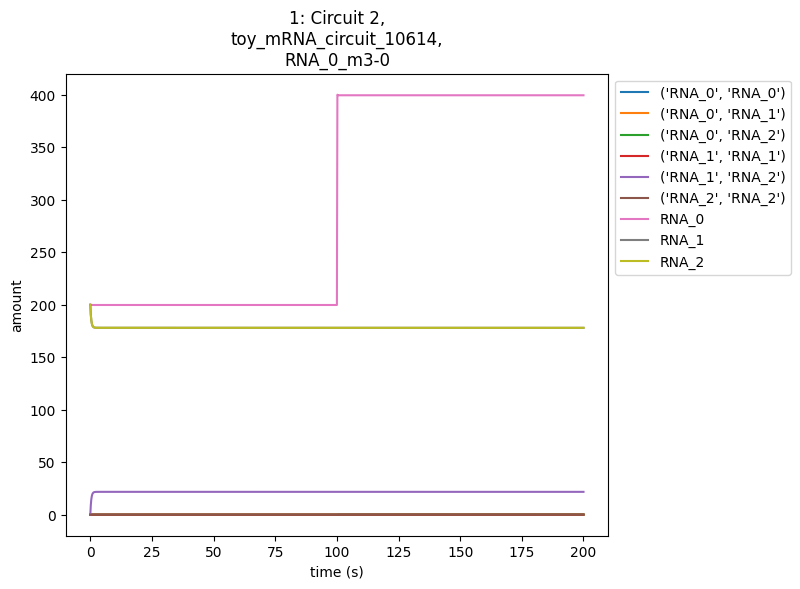

In [29]:
fig = plt.figure(figsize=(7,6))

tdisplay = [0, len(tss) + len(tyy)]
ax = plt.subplot(1,1,1)
plt.plot(np.concatenate([tss, tyy + tss[-1]])[tdisplay[0]:tdisplay[1]], np.concatenate([b_copynumbers[chosen_circuit_idx].T, b_new_copynumbers[chosen_circuit_idx].T])[tdisplay[0]:tdisplay[1]])
circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
plt.title(f'{chosen_circuit_idx}: {circ_type},\n{circuits[chosen_circuit_idx].name},\n{circuits[chosen_circuit_idx].subname}')
plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

Directly calculate precision.

In [30]:
def calc_precision(initial, final, signal_species_idx):

    signal_0 = initial[signal_species_idx]
    signal_1 = final[signal_species_idx]

    signal_diff = signal_1 - signal_0
    output_diff = final - initial


    denom = jnp.where(signal_0 != 0, signal_diff / signal_0, 1)
    numer = jnp.where((initial != 0).astype(int),
                        output_diff / initial, 1)
    precision = jnp.absolute(jnp.divide(
        numer, denom))
    return jnp.divide(1, precision)

initial = b_new_copynumbers[chosen_circuit_idx][:, 0]
final = b_new_copynumbers[chosen_circuit_idx][:, -1]

print('Precision is calculated directly for this circuit as:')
precision = calc_precision(initial, final, signal_species_idx)
for p, s in zip(precision, circuits[chosen_circuit_idx].model.species):
    print(s, ':', p)

Precision is calculated directly for this circuit as:
Species: ('RNA_0', 'RNA_0') : 0.333339
Species: ('RNA_0', 'RNA_1') : 1.0005652
Species: ('RNA_0', 'RNA_2') : 1.0005652
Species: ('RNA_1', 'RNA_1') : 1770.6678
Species: ('RNA_1', 'RNA_2') : 1903.7642
Species: ('RNA_2', 'RNA_2') : 1770.6678
Species: RNA_0 : 1.0
Species: RNA_1 : 3538.8245
Species: RNA_2 : 3538.8245


### Sensitivity and precision

Do the sensitivity and precision make sense? These are important measures of a circuit's signal response. As a reminder, the equations are the following:

$$ Sensitivity = | \frac{(O_{peak} - O_1) / O_1}{(I_2 - I_1) / I_1} |$$

$$ Precision =  | \frac{(O_2 - O_1)/O_1}{(I_2 - I_1) / I_1} |^{-1} $$

The sensitivity basically measures how much more the output changes in response to the signal compared to the change in the signal, while the precision measures how closely the output readapts to a steady states proportional to the change in the signal, so how well does the output adapt to the signal.

#### Assumptions

For biological circuits where the interactions are minimal and essentially nothing is happening ("null circuits"), we would expect there to be no reaction to a signal change. Therefore, the output change would be ero and the precision would have a zero denominator, making it infinite. The sensitivity would have the same thing in the numerator, making sensitivity zero for null circuits. Numerical imprecision and assumptions about baseline interaction rates mean that infinity becomes a very large number and zero becomes a very small number in the negative exponentials. We can observe this in our circuits below, selecting two null circuits:

In [31]:
null_circs = data[np.sum(data[get_true_interaction_cols(data, 'energies')], axis=1) == 0].iloc[list(np.arange(6))]
null_circs[['circuit_name', 'mutation_name', 'precision_wrt_species-6', 'sensitivity_wrt_species-6'] + get_true_interaction_cols(data, 'energies') + ['sample_name']]

,circuit_name,mutation_name,precision_wrt_species-6,sensitivity_wrt_species-6,energies_0-0,energies_0-1,energies_0-2,energies_1-0,energies_1-1,energies_1-2,energies_2-0,energies_2-1,energies_2-2,sample_name
183,toy_mRNA_circuit_0,RNA_1_m1-0,1.00268,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RNA_0
184,toy_mRNA_circuit_0,RNA_1_m1-0,3001.31270,0.000333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RNA_1
185,toy_mRNA_circuit_0,RNA_1_m1-0,3001.31270,0.000333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RNA_2
198,toy_mRNA_circuit_0,RNA_1_m1-5,1.00268,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RNA_0
199,toy_mRNA_circuit_0,RNA_1_m1-5,3001.31270,0.000333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RNA_1
200,toy_mRNA_circuit_0,RNA_1_m1-5,3001.31270,0.000333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,RNA_2


We confirm this by resimulate null circuit locally:

In [32]:
ref_null = data[(data['circuit_name'] == null_circs['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit')]
null_circuits = batch_load(null_circs.iloc[[0, -1]], ref_null, og_dir, config)

In [33]:
starting_states = np.asarray([nc.qreactions.quantities for nc in null_circuits])
reverse_rates = np.asarray([nc.qreactions.reactions.reverse_rates for nc in null_circuits])
copynumbers_null, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

copynumbers_null = np.swapaxes(copynumbers_null, 1, 2)

steady_states_null = (copynumbers_null[:, :, -1] * ((signal.onehot == 0) * 1)) + \
    (copynumbers_null[:, :, 0] *
     signal_target) * signal.onehot

new_copynumbers_null, tyy = simulate_steady_states(
    y0=steady_states_null, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

new_copynumbers_null = np.swapaxes(new_copynumbers_null, 1, 2)


# Fix first entry for signal species -> Warning: deletes final element in simulated data
for i, nc in enumerate(null_circuits):
    if not nc.use_prod_and_deg:
        new_copynumbers_null[i, :, :] = np.concatenate([np.expand_dims(copynumbers_null[i, :, -1], axis=1), new_copynumbers_null[i, :, :-1]], axis=1)


Done:  0:00:23.588431
Done:  0:00:22.357427


In [34]:

chid = 1

initial = new_copynumbers_null[chid, :, 0]
final = new_copynumbers_null[chid, :, -1]
output_diff = np.absolute(final - initial) / initial

precision = calc_precision(
    initial, final,
    signal_species_idx=signal_species_idx)

print('Precision for null circuit:\n')
for p, s in zip(precision, null_circuits[chid].model.species):
    print(s, ':', p)
    
print(f'\n\nThe relative change in the final and starting amounts for\n'
      'the output is small but non-zero, which is why their precision is not infinite:')
for o, s in zip(output_diff[-3:], null_circuits[chid].model.species[-3:]):
    print(s, ':', o)

Precision for null circuit:

Species: ('RNA_0', 'RNA_0') : 0.33333322
Species: ('RNA_0', 'RNA_1') : 1.000668
Species: ('RNA_0', 'RNA_2') : 1.000668
Species: ('RNA_1', 'RNA_1') : 1498.5682
Species: ('RNA_1', 'RNA_2') : 1498.3184
Species: ('RNA_2', 'RNA_2') : 1498.5682
Species: RNA_0 : 1.0
Species: RNA_1 : 2993.2915
Species: RNA_2 : 2993.2915


The relative change in the final and starting amounts for
the output is small but non-zero, which is why their precision is not infinite:
Species: RNA_0 : 1.0000004
Species: RNA_1 : 0.0003340805
Species: RNA_2 : 0.0003340805


As seen above, even the signal species $RNA_0$ does not have a precision of exactly $1$ due to numerical precision.

A circuit with high precision and high sensitivity on the other hand would have a final output that is very close to the initial output state, while having a big change in the transitory amount (the 'overshoot'). These kinds of circuits are highly adaptable and thus sought after, as investigated by ["Defining Network Topologies that Can Achieve Biochemical Adaptation (2009)"](https://www.cell.com/fulltext/S0092-8674(09)00712-0). Below, we examine the relationship between precision, sensitivity, and overshoot to find that the most adaptable circuits have a high overshoot.

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.98, 'Sensitivity vs. precision, $RNA_0$ excluded')

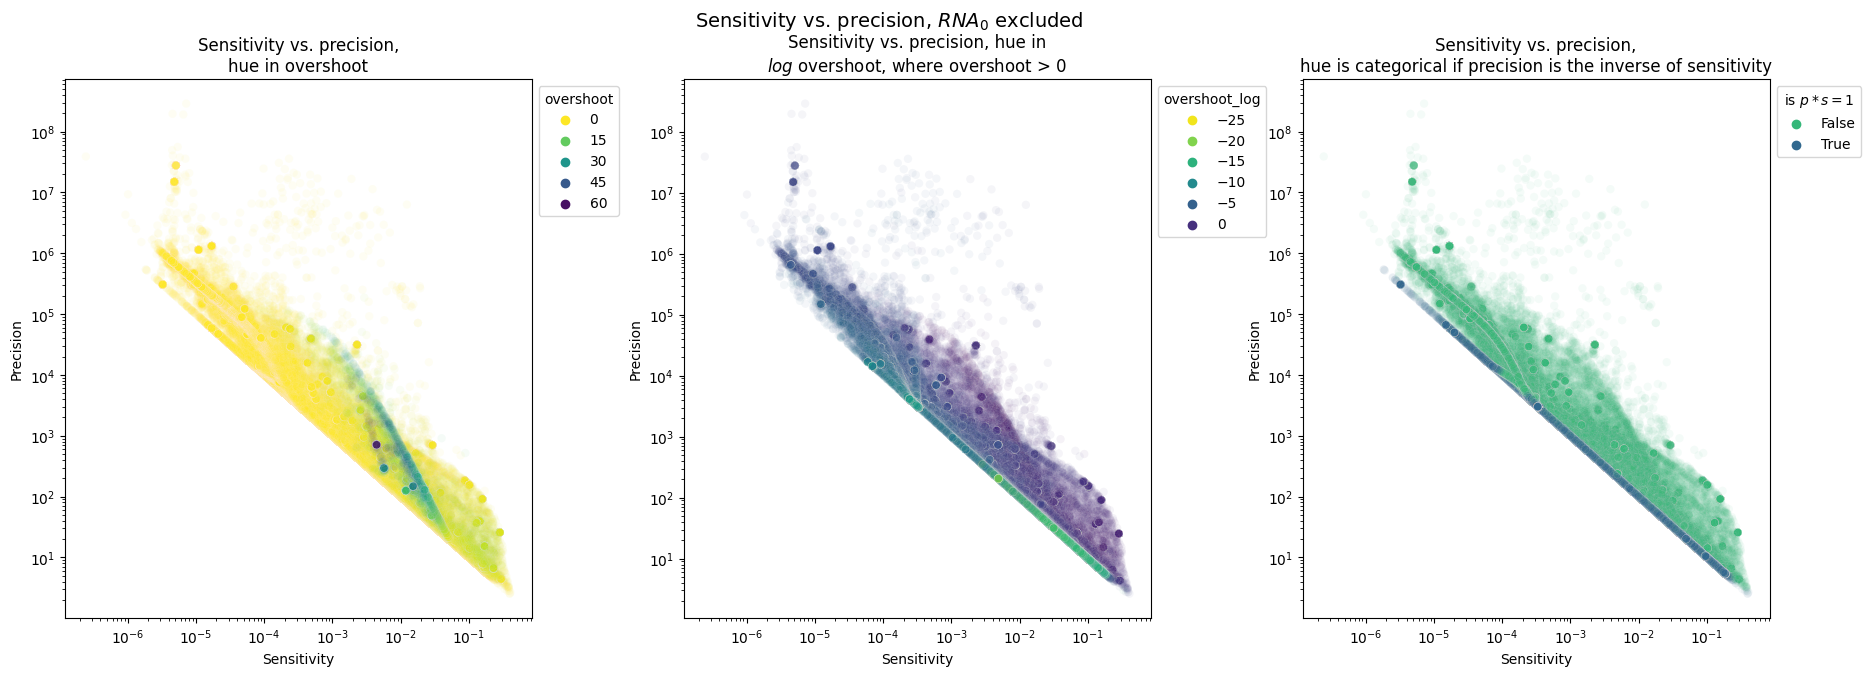

In [35]:
fig = plt.figure(figsize=(22, 7))
fig.subplots_adjust(wspace=0.325)

ax = plt.subplot(1,3,1)
sns.scatterplot(data[data['sample_name'] != 'RNA_0'].sort_values(by='overshoot'), x='sensitivity_wrt_species-6', y='precision_wrt_species-6', 
                hue='overshoot', alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Precision')
plt.title('Sensitivity vs. precision,\nhue in overshoot')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))

data['overshoot_log'] = np.log(data['overshoot'])
ax = plt.subplot(1,3,2)
sns.scatterplot(data[(data['sample_name'] != 'RNA_0') & (data['overshoot'] > 0)].sort_values(by='overshoot_log', ascending=False), 
                x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='overshoot_log', alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Precision')
plt.title('Sensitivity vs. precision, hue in\n$log$ overshoot, where overshoot > 0')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))

ax = plt.subplot(1,3,3)
# data['is $p * s = 1$'] = data['sensitivity_wrt_species-6'] == (1 / data['precision_wrt_species-6'])
data['is $p * s = 1$'] = (data['sensitivity_wrt_species-6'] * data['precision_wrt_species-6'] > 1.0 - 1e-1) & (data['sensitivity_wrt_species-6'] * data['precision_wrt_species-6'] < 1.0 + 1e-1)
sns.scatterplot(data[data['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', y='precision_wrt_species-6', 
                hue='is $p * s = 1$', alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Precision')
plt.title('Sensitivity vs. precision,\nhue is categorical if precision is the inverse of sensitivity')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))

plt.suptitle('Sensitivity vs. precision, $RNA_0$ excluded', fontsize=14)


It should be noted that each point on the scatterplot is the respective sensitivity and precision of an individual species with respect to the signal, with all bound intermediate species having been excluded. There are several interesting things revealed by this sensitivity vs. precision comparison. 

1. A diagonal line runs along $precision * sensitivity = 1$, which happens when the output peaks at the same point that it eventually steadies out at, or when overshoot is around 0. 
2. Islands of circuits with similar sensitivity and precision can be found alongside highly scattered circuits. 
3. A few secondary ridges appear, such as the ridge in the leftmost figure highlighted by the high overshoot or the ridge extending from ca. $sensitivity = 10^{-3.5}$ and $precision = 10^{3.5}$ up and then diagonally to the left. This could be related to null circuits with non-zero overshoots.


Text(0.5, 0.98, 'Closer look at sensitivity')

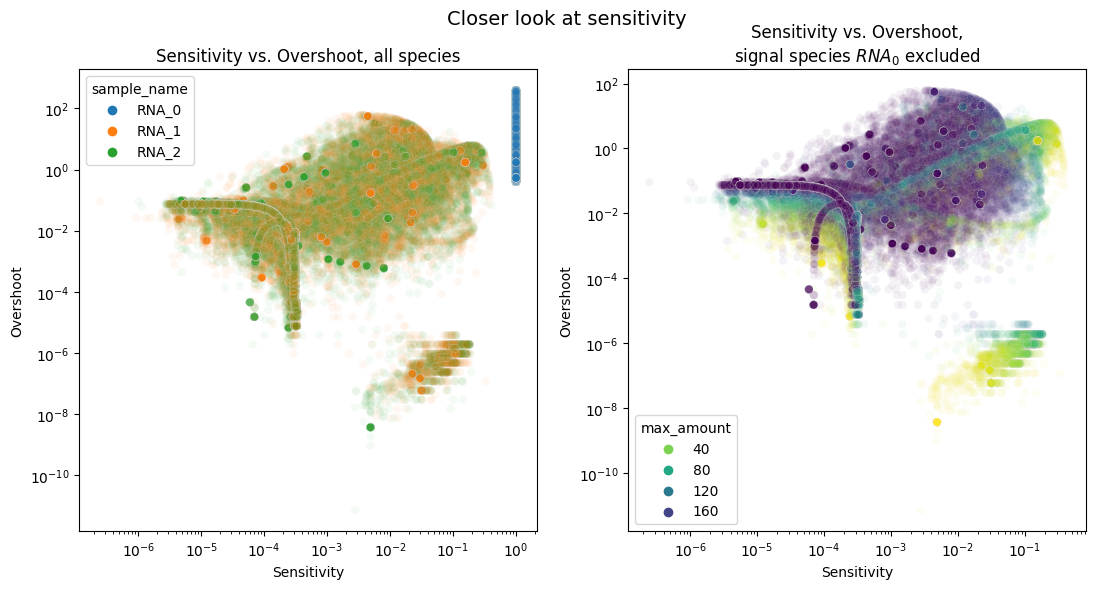

In [36]:
fig = plt.figure(figsize=(13, 6))
fig.subplots_adjust(hspace=0.425)

ax = plt.subplot(1,2,1)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='overshoot', hue='sample_name', alpha=0.05)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Overshoot')
plt.title('Sensitivity vs. Overshoot, all species')

ax = plt.subplot(1,2,2)
sns.scatterplot(data[data['sample_name'] != signal_species], x='sensitivity_wrt_species-6', y='overshoot', hue='max_amount', alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Overshoot')
plt.title('Sensitivity vs. Overshoot,\nsignal species $RNA_0$ excluded')

plt.suptitle('Closer look at sensitivity', fontsize=14)



#### Quick closer look at Overshoot

Text(0.5, 0.98, 'Sensitivity vs. Max amount')

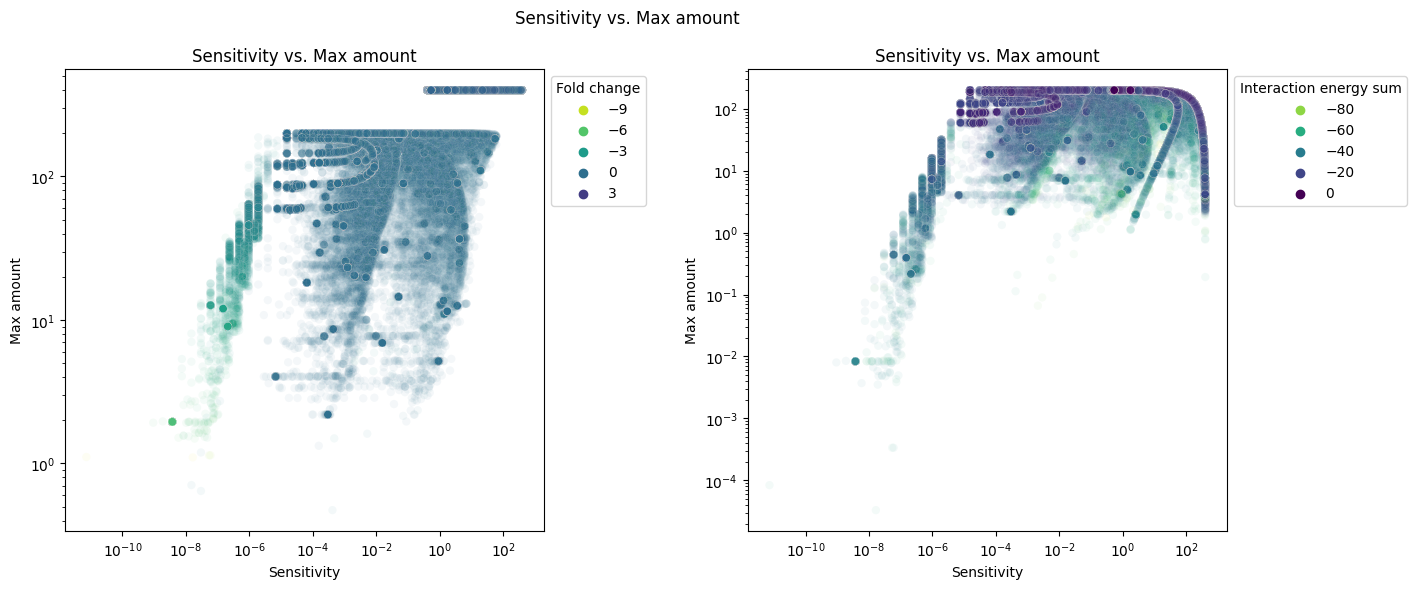

In [37]:
fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(hspace=0.425, wspace=0.425)

ax = plt.subplot(1,2,1)
sns.scatterplot(data, x='overshoot', y='max_amount', 
                hue=np.log(data['fold_change']), alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Max amount')
plt.title('Sensitivity vs. Max amount')
plt.legend(title='Fold change')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))

ax = plt.subplot(1,2,2)
sns.scatterplot(data, x='overshoot', y='min_amount', 
                hue=np.sum(data[get_true_interaction_cols(data, 'energies')], axis=1), alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Max amount')
plt.title('Sensitivity vs. Max amount')
plt.legend(title='Interaction energy sum')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))

plt.suptitle('Sensitivity vs. Max amount')

Back to sensitivity...

Text(0.5, 0.98, 'Sensitivity vs. Max amount')

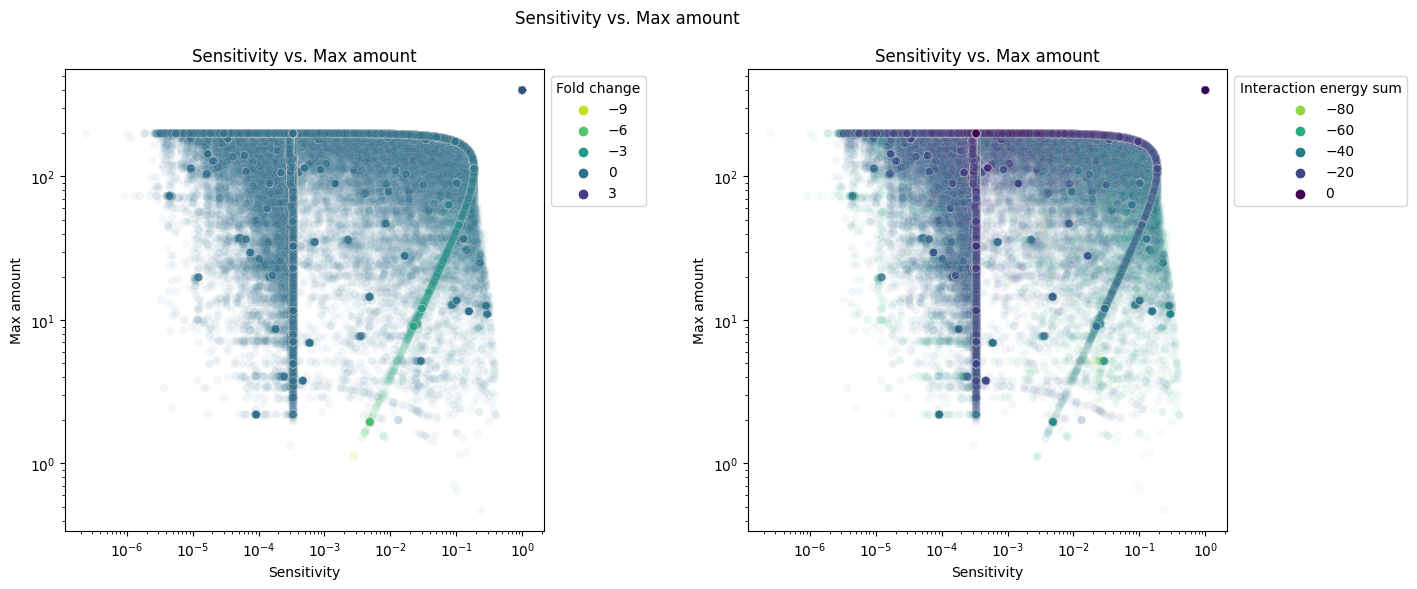

In [38]:
fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(hspace=0.425, wspace=0.425)

# ax = plt.subplot(1,2,1)
# sns.scatterplot(data, x='sensitivity_wrt_species-6', y='max_amount', hue='fold_change', alpha=0.05, palette='viridis_r')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Sensitivity')
# plt.ylabel('Max amount')
# plt.title('Sensitivity vs. Max amount')

ax = plt.subplot(1,2,1)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='max_amount', 
                hue=np.log(data['fold_change']), alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Max amount')
plt.title('Sensitivity vs. Max amount')
plt.legend(title='Fold change')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))

ax = plt.subplot(1,2,2)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='max_amount', 
                hue=np.sum(data[get_true_interaction_cols(data, 'energies')], axis=1), alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Max amount')
plt.title('Sensitivity vs. Max amount')
plt.legend(title='Interaction energy sum')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))

plt.suptitle('Sensitivity vs. Max amount')

The overshoot is affected numerically by simulation parameters like the number of starting species, which is 200 for this dataset. While this parameter is adjustable, it is based on the average number of RNA species found in a cell. Depending on circuit dynamics, certain overrepresented circuits will produce similar output steady states, which gives rise to the different ridges seen in the sensitivity vs. overshoot plot when the color is based on the maximum amount each species achieved. 

### Investigate discrepancy

There is a discrepancy between the analytics that were previously calculated and the analytics calculated here from the same circuit, even though dynamics are the same. The differences are small in small numbers and big in large numbers, meaning there is a high chance this is due to a difference in numerical estimation of steady states depending on the exact $dt$ and number of time steps used by the solver.

In [39]:
print('Locally calculated precision and sensitivity:\n')
print(df_calculated[['precision_wrt_species-6', 'sensitivity_wrt_species-6']])
print('\nPrecision and sensitivity calculated locally but with native functions:')
df_report[['precision_wrt_species-6', 'sensitivity_wrt_species-6']]


Locally calculated precision and sensitivity:

   precision_wrt_species-6  sensitivity_wrt_species-6
0                 0.334208                   2.992150
1                 1.003173                   0.996837
2                 1.003173                   0.996837
3              1775.283691                   0.000615
4              1908.726807                   0.000524
5              1775.283691                   0.000615
6                 1.002607                   1.000000
7              3548.049316                   0.000307
8              3548.049316                   0.000307

Precision and sensitivity calculated locally but with native functions:


,precision_wrt_species-6,sensitivity_wrt_species-6
0,0.33420628,2.9921641
1,1.0031937,0.9968164
2,1.0031937,0.9968164
3,1714.1042,0.000605828
4,1953.3573,0.0005119391
5,1714.1042,0.000605828
6,1.0026071,1.0
7,3426.5508,0.00030286596
8,3426.5508,0.00030286596


### Resimulate circuits with native functions

While numerical estimation differences could exist, if the exact same setting are used and the same functions are called on these, the result should be the same as the previously simulated experimental run. We can verify this by inputing the parameters that we got from the original configuration file into the modelling function. This will write the results to a subdirectory in the `data` directory, under `tests`.

In [40]:
# chosen_circuit_idx = 1

# stop
config, data_writer = script_preamble(config=config, data_writer=None)

config['simulation']['device'] = 'gpu'
config['experiment']['no_numerical'] = False
config['experiment']['no_visualisations'] = False


In [41]:
circuits1 = batch_load(circ_rows1, ref_c1, og_dir, config)
circuits2 = batch_load(circ_rows2, ref_c2, og_dir, config)
circuits = circuits1 + circuits2
circuit_modeller = CircuitModeller(result_writer=data_writer, config=config)

In [42]:

circuits = circuit_modeller.batch_circuits(
    circuits=circuits,
    write_to_subsystem=True,
    batch_size=config['simulation'].get('batch_size', 100),
    methods={
        # "compute_interactions": {},
        "init_circuits": {'batch': True},
        "simulate_signal_batch": {'ref_circuit': None,
                                'batch': config['simulation']['use_batch_mutations']}
        # "write_results": {'no_visualisations': False,
        #                   'no_numerical': False}
    })

circuit_manager.py:batch_circuits():565: 	From 58 circuits, a total of 58 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():572: 		Starting new round of viable circuits (0 - 58 / 58) WARNING
circuit_manager.py:batch_circuits():590: 		Making subcircuits 0 - 58 took 7.8e-05s WARNING
circuit_manager.py:batch_circuits():596: 	Batching 0 - 20000 circuits (out of 0 - 58 (total: 58)) (Circuits: 0 - 58 of 58) WARNING
circuit_manager.py:run_batch():627: 		Running 58 Subcircuits - toy_mRNA_circuit_10614: init_circuits WARNING


Done:  0:00:41.868727


circuit_manager.py:run_batch():663: 		Method init_circuits took 42.201092s WARNING
circuit_manager.py:run_batch():627: 		Running 58 Subcircuits - toy_mRNA_circuit_10614: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():487: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():337: 		Simulating signal took 41.835612s WARNING


Done:  0:00:41.833930


circuit_manager.py:simulate_signal_batch():393: 		Calculating analytics took 8.475698s WARNING
circuit_manager.py:run_batch():663: 		Method simulate_signal_batch took 51.315454s WARNING
circuit_manager.py:batch_circuits():610: Single batch: 0:01:33.522476 
Projected time: 93.522476s 
Total time: 0:01:33.522492 WARNING


In [43]:
b_copynumbers_new_sim = np.asarray([c.result_collector.get_result('signal').data for c in circuits])

#### Write results 

We are just writing the results of the simulation separately with the `circuit_modeller` in case something goes wrong with the writing process. This way we can at least view the results locally.

In [44]:
circuits2 = circuit_modeller.batch_circuits(
    circuits=circuits,
    write_to_subsystem=True,
    batch_size=config['simulation'].get('batch_size', 100),
    methods={
        "write_results": {'no_visualisations': False,
                          'no_numerical': False}
    })

circuit_manager.py:batch_circuits():565: 	From 58 circuits, a total of 58 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():572: 		Starting new round of viable circuits (0 - 58 / 58) WARNING
circuit_manager.py:batch_circuits():590: 		Making subcircuits 0 - 58 took 7.4e-05s WARNING
circuit_manager.py:batch_circuits():596: 	Batching 0 - 20000 circuits (out of 0 - 58 (total: 58)) (Circuits: 0 - 58 of 58) WARNING
circuit_manager.py:run_batch():627: 		Running 58 Subcircuits - toy_mRNA_circuit_10614: write_results WARNING


circuit_manager.py:run_batch():663: 		Method write_results took 19.549405s WARNING
circuit_manager.py:batch_circuits():610: Single batch: 0:00:19.552947 
Projected time: 19.552946999999996s 
Total time: 0:00:19.552959 WARNING


### Analytics from native functions

The analytics calculated by the modeller do differ from those calculated with local functions, but are the same as the analytics saved from the original simulation run. Further analysis below confirms that small numerical differences result in large differences in certain analytics like precision, which are sensitive to small changes in its denominator.

In [45]:
analytics_s = [c.result_collector.get_result('signal').analytics for c in circuits]

In [46]:
print('Precision calculated with native functions vs. calculated locally:\n')
initial = b_new_copynumbers[chid][:, 0]
final = b_new_copynumbers[chid][:, -1]
precision = calc_precision(initial, final, signal_species_idx)
pd.DataFrame(data=zip(circuits[chosen_circuit_idx].model.species, precision, analytics_s[chid]['precision_wrt_species-6'].squeeze()),
             columns=['Species', 'Simulated locally', 'Simulated with native functions'])

Precision calculated with native functions vs. calculated locally:



,Species,Simulated locally,Simulated with native functions
0,"Species: ('RNA_0', 'RNA_0')",0.333339,0.33420628
1,"Species: ('RNA_0', 'RNA_1')",1.0005652,1.0031937
2,"Species: ('RNA_0', 'RNA_2')",1.0005652,1.0031937
3,"Species: ('RNA_1', 'RNA_1')",1770.6678,1714.1042
4,"Species: ('RNA_1', 'RNA_2')",1903.7642,1953.3573
5,"Species: ('RNA_2', 'RNA_2')",1770.6678,1714.1042
6,Species: RNA_0,1.0,1.0026071
7,Species: RNA_1,3538.8245,3426.5508
8,Species: RNA_2,3538.8245,3426.5508


In the table above, both $RNA_1$ and $RNA_2$ have significant differences in their precision values. Yet looking at the traces for the different simulation methods, they are nearly identical, as shown below.

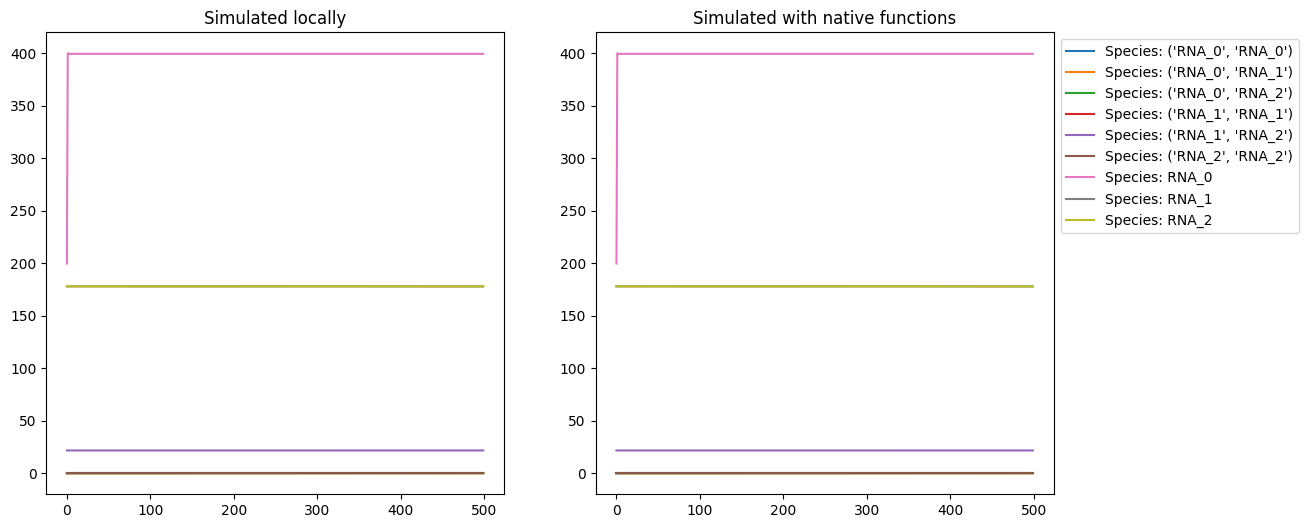

In [47]:
fig = plt.figure(figsize=(13, 6))

ax = plt.subplot(1,2,1)
plt.plot(b_new_copynumbers[chosen_circuit_idx].T)
plt.title('Simulated locally')

ax = plt.subplot(1,2,2)
plt.plot(b_copynumbers_new_sim[chosen_circuit_idx].T)
plt.title('Simulated with native functions')
plt.legend(circuits[chosen_circuit_idx].model.species)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))


A closer inspection of the denominator of the precision calculation shows that tiny numerical differences are indeed the cause for this discrepancy.

In [48]:
chosen_circuit_idx= 1   
s0 = b_new_copynumbers[chosen_circuit_idx][signal_species_idx, 0]
s1 = b_new_copynumbers[chosen_circuit_idx][signal_species_idx, 1]
o0 = b_new_copynumbers[chosen_circuit_idx][:, 0]
o1 = b_new_copynumbers[chosen_circuit_idx][:, -1]
    
print('Locally simulated circuits (for species RNA_2):\n')
print('\tSignal diff: ', s1 - s0)
print('\tOutput diff: ', (o1 - o0)[-1])
print('\tScaled signal diff: ', (s1 - s0)/s0)
print('\tScaled output diff: ', ((o1 - o0)/o0)[-1])
prec = np.divide(1,
                 np.abs(
                     ((o1 - o0) / o0) / ((s1 - s0) / s0)
                 )
)
print('\nPrecision for species RNA_2:', prec[-1])

Locally simulated circuits (for species RNA_2):

	Signal diff:  200.25525
	Output diff:  -0.050308228
	Scaled signal diff:  1.0025557
	Scaled output diff:  -0.00028256534

Precision for species RNA_2: 3548.0493


In [49]:
s0 = b_copynumbers_new_sim[chosen_circuit_idx][signal_species_idx, 0]
s1 = b_copynumbers_new_sim[chosen_circuit_idx][signal_species_idx, 1]
o0 = b_copynumbers_new_sim[chosen_circuit_idx][:, 0]
o1 = b_copynumbers_new_sim[chosen_circuit_idx][:, -1]
    
print('Circuits simulated with native functions (for species RNA_2):\n')
print('\tSignal diff: ', s1 - s0)
print('\tOutput diff: ', (o1 - o0)[-1])
print('\tScaled signal diff: ', (s1 - s0)/s0)
print('\tScaled output diff: ', ((o1 - o0)/o0)[-1])
prec = np.divide(1,
                 np.abs(
                     ((o1 - o0) / o0) / ((s1 - s0) / s0)
                 )
)
print('\nPrecision for species RNA_2:', prec[-1])

Circuits simulated with native functions (for species RNA_2):

	Signal diff:  200.25693
	Output diff:  -0.052093506
	Scaled signal diff:  1.0025725
	Scaled output diff:  -0.00029258945

Precision for species RNA_2: 3426.5505


## Consolidation

The large discrepancies that can arise from small estimation differences are something that may affect downstream learning tasks. However, in general these differences arise with very large numbers that have poor correspondence to real units and may as well be considered infinity. Therefore, the qualitative aspects are more important in these cases and should not detract from the predictive power of the model for selecting different types of circuits.